# IST 718: Big Data Analytics

- Professor: Daniel Acuna <deacuna@syr.edu>

## General instructions:

- You are welcome to discuss the problems with your classmates but __you are not allowed to copy any part of your answers either from your classmates or from the internet__
- You can put the homework files anywhere you want in your http://notebook.acuna.io workspace but _do not change_ the file names. The TAs and the professor use these names to grade your homework.
- Remove or comment out code that contains `raise NotImplementedError`. This is mainly to make the `assert` statement fail if nothing is submitted.
- The tests shown in some cells (i.e., `assert` and `np.testing.` statements) are used to grade your answers. **However, the professor and TAs will use __additional__ test for your answer. Think about cases where your code should run even if it passess all the tests you see.**
- Before downloading and submitting your work through Blackboard, remember to save and press `Validate` (or go to 
`Kernel`$\rightarrow$`Restart and Run All`). 
- Good luck!

In [1]:
# Load the packages needed for this part
# create spark and sparkcontext objects
from pyspark.sql import SparkSession
import numpy as np

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

import pyspark
from pyspark.ml import feature, regression, Pipeline
from pyspark.sql import functions as fn, Row
from pyspark import sql

import matplotlib.pyplot as plt
import pandas as pd

# Part 1: Admission analysis

In this assignment, you will have to do an analysis on graduate admission dataset. 

# Admission data analysis
```console
1. Title: Graduate Admission Data

2. Sources:
    Mohan S Acharya, Asfia Armaan, Aneeta S Antony : A Comparison of Regression Models for Prediction of Graduate Admissions, IEEE International Conference on Computational Intelligence in Data Science 2019
    
3. Number of Instances: 400

4. Numer of Attributes: 8 + numeric chance of admit 

5. Attribute information:
    
    1. Region: A,B,C,D,E
    2. GRE_Score: out of 340
    3. TOEFL_Scores: out of 120 
    4. University_Rating: out of 5 
    5. SOP (Statement of Purpose): out of 5
    6. LOR (Letter of Recommendation): out of 5 
    7. CGPA (Undergraduate GPA): out of 10 
    8. Research (Research Experience): either 0 or 1 
    9. Chance_of_Admit: ranging from 0 to 1 
```

In [2]:
# Load the data
admission_df = spark.createDataFrame(pd.read_csv('Admission_Predict.csv', sep=','))

# 1. Explore the data

With big data, datasets can be too big to bring them into the Spark client. However, we can use the `limit` method of a dataframe to limit the number of rows to bring as a Pandas dataframe.

Create a dataframe `admission_sample_df` with the first 30 rows of `admission_df`

In [3]:
# create 'admission_sample_df'
# YOUR CODE HERE
admission_sample_df = admission_df.limit(30)
#raise NotImplementedError()

In [4]:
# 1 pts - right number of rows
np.testing.assert_equal(admission_sample_df.count(), 30)

**(7 pts)** Below, transform `admission_sample_df` into a Pandas dataframe and do a scatter plot of `GRE_Score` vs `TOEFL_Score`. In addition, grouping each point with different color based on `Chance_of_Admit`. If the chance over 0.6, colored the points blue; otherwise, colored the points red. Last, describe what you find? (Remember to add **axis titles**)

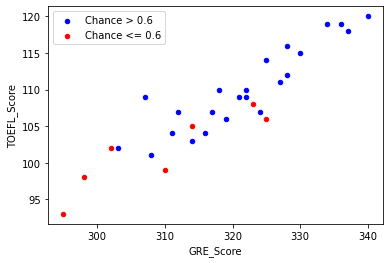

In [5]:
# 5 pts: Scatter plot of GRE_Score vs TOEFL_Score
# YOUR CODE HERE
pandas_df_admission = admission_sample_df.toPandas()
ax = plt.subplot()
pandas_df_admission.query("Chance_of_Admit > 0.6").plot(kind ='scatter',x="GRE_Score",y="TOEFL_Score",color="b",ax=ax,label= "Chance > 0.6")
pandas_df_admission.query("Chance_of_Admit <= 0.6").plot(kind='scatter',x="GRE_Score",y="TOEFL_Score",color="r",ax=ax,label="Chance <= 0.6")
plt.legend()
#raise NotImplementedError()

In [6]:
# 2 pts: What you find based on the scatter plot?
# YOUR CODE HERE
# For GRE score less than approximately 325 and TOEFL score less than approximately 108, the chances of getting an admit is less than 0.6
# But also, the chance of getting an admit is > 0.6 even if the scores are GRE and TOEFL scores are less, this could be because of other factors effecting the chance of admit
# As GRE scores are increasing, TOEFL are also increasing. GRE and Toefl are correlated
# raise NotImplementedError()

## Perform correlations between SOP, LOR, and CGPA

Create a `admission_corr_df` dataframe that contains the correlations between `SOP` and `LOR` as a column `corr_SOP_LOR`, between `LOR` and `CGPA` as `corr_LOR_CGPA`, and `SOP` and `CGPA` as `corr_SOP_CGPA`. (Using admission_df)

In [7]:
# create 'admission_corr_df' here
# YOUR CODE HERE
df = sc.parallelize([(admission_df.corr('SOP','LOR'),admission_df.corr('CGPA','LOR'),admission_df.corr('SOP','CGPA'))])
admission_corr_df = df.toDF(["corr_SOP_LOR","corr_LOR_CGPA","corr_SOP_CGPA"])
#raise NotImplementedError()

In [8]:
# 3 pts
np.testing.assert_equal(set(admission_corr_df.columns), 
                        {'corr_SOP_LOR', 'corr_LOR_CGPA', 'corr_SOP_CGPA'})
np.testing.assert_almost_equal(list(admission_corr_df.first().asDict().values()),
                               [0.7295925366175836, 0.6702112958281646, 0.718143958057528], decimal=3)

## Compute mean and standard deviation Change_of_Admit for regions

Create `region_chance_df` with the column `region`, `avg_chance`, and `sd_chance`, where `avg_chance` is the average chance of admit in different regions and `sd_chance` is the standard deviation of chance of admit. Sort the resulting dataframe from highest to lowest average chance of admit.

In [9]:
# YOUR CODE HERE
region_chance_df = admission_df.groupBy('region').\
agg(fn.mean('Chance_of_Admit').alias("avg_chance"),fn.stddev_samp('Chance_of_admit').alias("sd_chance")).\
    sort('avg_chance',ascending=False) 
#raise NotImplementedError()

In [10]:
# 5 pts
np.testing.assert_array_almost_equal(
    (region_chance_df.orderBy('region').select('avg_chance').\
     rdd.map(lambda x: list(x.asDict().values())).collect()),
[[0.7283529411764705],
 [0.712],
 [0.7020000000000001],
 [0.734],
 [0.7501538461538463]], decimal=3)

np.testing.assert_array_almost_equal(
    (region_chance_df.orderBy('region').select('sd_chance').\
     rdd.map(lambda x: list(x.asDict().values())).collect()),
[[0.1474533587179311],
 [0.13247461571759256],
 [0.14784014630931444],
 [0.14602022038712573],
 [0.1364103678667368]], decimal=3)

# Feature Engineering

## Dummy variables for region
Create a dataframe `dummy_df` with columns `region` as dummy variables, and columns `GRE_Score`, `TOEFL_Score`, `CGPA`, `University_Rating`, and `Chance_of_Admit`. Use region B as the baselines and name the dummy variables `region_A` for region `A` and so on. The dataframe `dummy_df` should not contain the column `region` but only its dummy variable representations. **All column types should be float or integer.**

In [11]:
# create dummy_df below
# YOUR CODE HERE
df2 = admission_df.withColumn('Region_A',(fn.col('region')=="A").cast("int"))
df2 = df2.withColumn('region_B',(fn.col('region')=="B").cast("int"))
df2 = df2.withColumn('region_C',(fn.col('region')=="C").cast("int"))
df2 = df2.withColumn('region_D',(fn.col('region')=="D").cast("int"))
df2 = df2.withColumn('region_E',(fn.col('region')=="E").cast("int"))
dummy_df = df2.select("region_A","region_C","region_D","region_E","GRE_Score","TOEFL_Score","CGPA","University_Rating","Chance_of_Admit")
#dummy_df.show()
#raise NotImplementedError()

In [12]:
# 5 pts
np.testing.assert_equal(len(dummy_df.columns), 9)
np.testing.assert_equal(dummy_df.select(fn.sum('Region_A')).first()['sum(Region_A)'], 85)
np.testing.assert_equal(dummy_df.select(fn.sum('Region_D')).first()['sum(Region_D)'], 85)

# Model comparison

In the next set of questions, you will use the splits below to fit, validate, and estimate the generalization error of your models. The `randomSplit` is called with a seed so that it does not change from what the professor used.

In [13]:
training_df, validation_df, testing_df = dummy_df.randomSplit([0.6, 0.3, 0.1], seed=0)
print("# points in training: ", training_df.count())
print("# points in validation: ", validation_df.count())
print("# points in testing: ", testing_df.count())

# points in training:  227
# points in validation:  126
# points in testing:  47


## Propose three regression models

In the next section, you will choose the best model to explain the data in `admission_df`. Select the right split of the data for the right step of the process (i.e., training, validation, and testing)

### Model 1: Fit model with only `GRE_Score`

Create a pipeline that takes **GRE_Score** as a feature to predict **Chance_of_Admit** and fits a linear regression model. You should start your pipeline by taking the appropriate column or columns from `dummy_df`. Assign the fit pipeline transformer to `pipe_model1`. Your pipeline must have one vector assembler followed by a linear regression.

In [14]:
# Create 'pipe_model1' below
# YOUR CODE HERE
#raise NotImplementedError()
pipe_model1 = Pipeline(stages =[feature.VectorAssembler(inputCols =['GRE_Score'],outputCol ='features'),
                      regression.LinearRegression(labelCol='Chance_of_Admit',featuresCol='features')]).fit(training_df)

In [15]:
# (5 pts)
np.testing.assert_equal(type(pipe_model1.stages[0]), feature.VectorAssembler)
np.testing.assert_equal(type(pipe_model1.stages[1]), regression.LinearRegressionModel)
np.testing.assert_array_equal(pipe_model1.stages[1].coefficients.shape, (1,))

### Model 2: Fit model with `GRE_Score` and `TOEFL_Score`

Follow the same idea as above and create a pipeline transformer `pipe_model2`

In [16]:
# YOUR CODE HERE
#raise NotImplementedError()
pipe_model2 = Pipeline(stages =[feature.VectorAssembler(inputCols =['GRE_Score','TOEFL_Score'],outputCol ='features'),
                      regression.LinearRegression(labelCol='Chance_of_Admit',featuresCol='features')]).fit(training_df)

In [17]:
# (5 pts)
np.testing.assert_equal(type(pipe_model2.stages[0]), feature.VectorAssembler)
np.testing.assert_equal(type(pipe_model2.stages[1]), regression.LinearRegressionModel)
np.testing.assert_array_equal(pipe_model2.stages[1].coefficients.shape, (2,))

### Model 3: Fit model with region, GRE_Score, TOEFL_Score, CGPA, and Univeristy_Rating

Follow the same idea as above and create a pipeline transformer `pipe_model3`. Remember that some features have been feature engineered. In particular, use the transformed columns in the order: region, GRE_Score, TOEFL_Score, CGPA, and Univeristy_Rating. Choose the columns from `dummy_df` appropriately.

In [18]:
# create `pipe_model2` below
# YOUR CODE HERE
#raise NotImplementedError()

pipe_model3 = Pipeline(stages =[feature.VectorAssembler(inputCols =['region_A','region_C','region_D','region_E','GRE_Score','TOEFL_Score','CGPA','University_Rating'],outputCol ='features'),
                      regression.LinearRegression(labelCol='Chance_of_Admit',featuresCol='features')]).fit(training_df)

In [19]:
# (5 pts)
np.testing.assert_equal(type(pipe_model3.stages[0]), feature.VectorAssembler)
np.testing.assert_equal(type(pipe_model3.stages[1]), regression.LinearRegressionModel)
np.testing.assert_array_equal(pipe_model3.stages[1].coefficients.shape, (8,))

# Compare models

### Estimate RMSE on validation data for the three models

Create three dataframes `rmse1_df`, `rmse2_df`, and `rmse3_df` for models 1, 2, and 3, respectively, with only column `rmse`

In [20]:
# create rmse1_df, rmse2_df, and rmse3_df dataframes below
# YOUR CODE HERE
#raise NotImplementedError()
p1 = pipe_model1.transform(validation_df)
rmse1 = p1.agg(fn.sqrt(fn.mean((fn.col('Chance_of_Admit')-fn.col('prediction'))**2)).alias('rmse')).collect()
rmse1_df = spark.createDataFrame(rmse1)

p2 = pipe_model2.transform(validation_df)
rmse2 = p2.agg(fn.sqrt(fn.mean((fn.col('Chance_of_Admit')-fn.col('prediction'))**2)).alias('rmse')).collect()
rmse2_df = spark.createDataFrame(rmse2)

p3 = pipe_model3.transform(validation_df)
rmse3 = p3.agg(fn.sqrt(fn.mean((fn.col('Chance_of_Admit')-fn.col('prediction'))**2)).alias('rmse')).collect()
rmse3_df = spark.createDataFrame(rmse3)

In [21]:
# display the answers here
rmse1_df.show()
rmse2_df.show()
rmse3_df.show()

+-------------------+
|               rmse|
+-------------------+
|0.08283242435572377|
+-------------------+

+-------------------+
|               rmse|
+-------------------+
|0.07570520768216206|
+-------------------+

+-------------------+
|               rmse|
+-------------------+
|0.06825953330162493|
+-------------------+



In [22]:
# (5 pts)
np.testing.assert_equal(rmse1_df.count(), 1)
np.testing.assert_equal(rmse2_df.count(), 1)
np.testing.assert_equal(rmse3_df.count(), 1)
np.testing.assert_equal(rmse1_df.columns, ['rmse'])
np.testing.assert_equal(rmse2_df.columns, ['rmse'])
np.testing.assert_equal(rmse3_df.columns, ['rmse'])

Assign the best cross validated model to a variable `best_model` below

In [23]:
# assign best model (the best pipeline transformer) to a variable best_model below
# YOUR CODE HERE
#raise NotImplementedError()
best_model = pipe_model3

In [24]:
# (1 pts)
np.testing.assert_equal(type(best_model), pyspark.ml.pipeline.PipelineModel)

### Estimate generalization performance with RMSE

Create a variable `rmse_best_df` that contains the RMSE of the best model on testing data

In [25]:
# create rmse_best_df
# YOUR CODE HERE
#raise NotImplementedError()
p_best = best_model.transform(testing_df)
rmse_best_df = p_best.agg(fn.sqrt(fn.mean((fn.col('Chance_of_Admit')-fn.col('prediction'))**2)).alias('rmse')).collect()
rmse_best_df = spark.createDataFrame(rmse_best_df)

In [26]:
# (2 pts)
np.testing.assert_equal(rmse_best_df.count(), 1)
np.testing.assert_equal(rmse_best_df.columns, ['rmse'])

**(1 pts)** What is the best estimated generalization performance of the best model? Answer in the cell below

In [27]:
# (1 pts)
# YOUR CODE HERE
#raise NotImplementedError()
#The best estimated generalization performance of the best model is root mean squared error.
rmse_best_df.show()
#it is 0.056 for the best model we considered.

+--------------------+
|                rmse|
+--------------------+
|0.056024696786660146|
+--------------------+



# Do inference with best model

Assume that model 3 is the best one. Redefine a new pipeline for this model called `pipe_model_best` and fit it to the **entire training data** (all of `dummy_df`).

In [28]:
# create `pipe_model_best` below
# YOUR CODE HERE
#raise NotImplementedError()
pipe_model_best = Pipeline(stages =[feature.VectorAssembler(inputCols =["region_A","region_C","region_D","region_E","GRE_Score","TOEFL_Score","CGPA","University_Rating"],
                                               outputCol ='features'),
                      regression.LinearRegression(labelCol='Chance_of_Admit',featuresCol='features')]).fit(dummy_df)

In [29]:
# (2 pts) check that the model was fitted correctly
np.testing.assert_equal(type(pipe_model_best.stages[0]), feature.VectorAssembler)
np.testing.assert_equal(type(pipe_model_best.stages[1]), regression.LinearRegressionModel)
np.testing.assert_array_equal(pipe_model_best.stages[1].coefficients.shape, (8,))

**(3 pts)** Assume that all features on `dummy_df` were comparable (i.e., standardized). Taking region B as the baseline, what are the top 2 most important features for *increasing chance of admit* and the top 2 most important features for *decreasing chance of admit*? Answer below with code and comments to support your answer

In [30]:
# YOUR CODE HERE
#raise NotImplementedError()
# The top 2 most important features for increasing chance of admit are CGPA(coefficient = 0.1366) and belonging to region D(coefficient=0.0205)
# The top 2 most important features for decreasing the chance of admit are region E(Coefficient= 0.0005) and GRE_Score(coefficient=0.0021)
pipe_model_best.stages[1].coefficients

DenseVector([0.0059, 0.0121, 0.0205, 0.0005, 0.0021, 0.0027, 0.1366, 0.0116])